# Convolutional Neural Networks for Image Classification (Computer Vision)

Convolutional Neural Networks (CNNs) are commonly used in tasks involving image analysis as they are designed to extract complex features from images due to its hierarchical nature. 

In this project, a simple CNN (from scratch) using TinyVGG architecture will be used to classify images into six different categories:

0. Building
1. Forest
2. Glacier
3. Mountain
4. Sea
5. Street

The dataset can be found here: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

Other datasets that are common benchmarks for image classification are CIFAR-10 and CIFAR-100 datasets.

## 0. Importing necessary libraries and tools

In [1]:
import os
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from helper_functions import accuracy_fn, print_train_time, plot_loss_curves

torch.manual_seed(42)

torch.__version__

'2.5.1+cpu'

## 1. Data Processing

We will be using OpenCV to process image data and convert each image into tensors later on for model training and evaluation. Each image is of dimension 150x150 and will have RBG colour channels.

In [2]:
# Map each output class into indices
OUTPUT_CLASSES = {
    'buildings' : 0,
    'forest' : 1,
    'glacier' : 2,
    'mountain' : 3,
    'sea' : 4,
    'street' : 5
}

train_data, test_data, train_targets, test_targets = [], [], [], []

# Loop through all the data and convert into numerical formats
for class_type in OUTPUT_CLASSES:
    train_files = os.listdir(f"data//seg_train//{class_type}")
    test_files = os.listdir(f"data//seg_test//{class_type}")
    
    for file in train_files:
        image = cv2.imread(f"data//seg_train//{class_type}//{file}")
        class_value = OUTPUT_CLASSES[class_type]

        if (image is not None) and (len(image) == 150) and (len(image[0]) == 150) and (len(image[0][0]) == 3):
            train_data.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(int))
            train_targets.append(class_value)

    for file in test_files:
        image = cv2.imread(f"data//seg_test//{class_type}//{file}")
        class_tensor = torch.tensor(OUTPUT_CLASSES[class_type])

        if (image is not None) and (len(image) == 150) and (len(image[0]) == 150) and (len(image[0][0]) == 3):
            test_data.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(int))
            test_targets.append(class_value)

len(train_data), len(test_data), len(train_targets), len(test_targets)

(13986, 2993, 13986, 2993)

In [3]:
# Let's see what a sample data looks like
test_data[0]

array([[[ 92, 119, 174],
        [114, 140, 189],
        [101, 124, 166],
        ...,
        [109, 148, 207],
        [110, 149, 208],
        [110, 149, 208]],

       [[ 86, 113, 160],
        [157, 181, 227],
        [141, 163, 204],
        ...,
        [106, 146, 205],
        [107, 147, 206],
        [107, 147, 206]],

       [[128, 152, 186],
        [138, 161, 195],
        [156, 176, 213],
        ...,
        [103, 145, 205],
        [103, 145, 205],
        [103, 145, 205]],

       ...,

       [[198, 207, 224],
        [198, 207, 224],
        [197, 206, 223],
        ...,
        [224, 230, 242],
        [226, 233, 243],
        [228, 235, 245]],

       [[195, 206, 224],
        [195, 206, 224],
        [195, 206, 224],
        ...,
        [224, 230, 242],
        [228, 235, 245],
        [232, 239, 249]],

       [[192, 205, 222],
        [192, 205, 222],
        [194, 205, 223],
        ...,
        [223, 229, 241],
        [230, 237, 247],
        [234, 241, 251]]

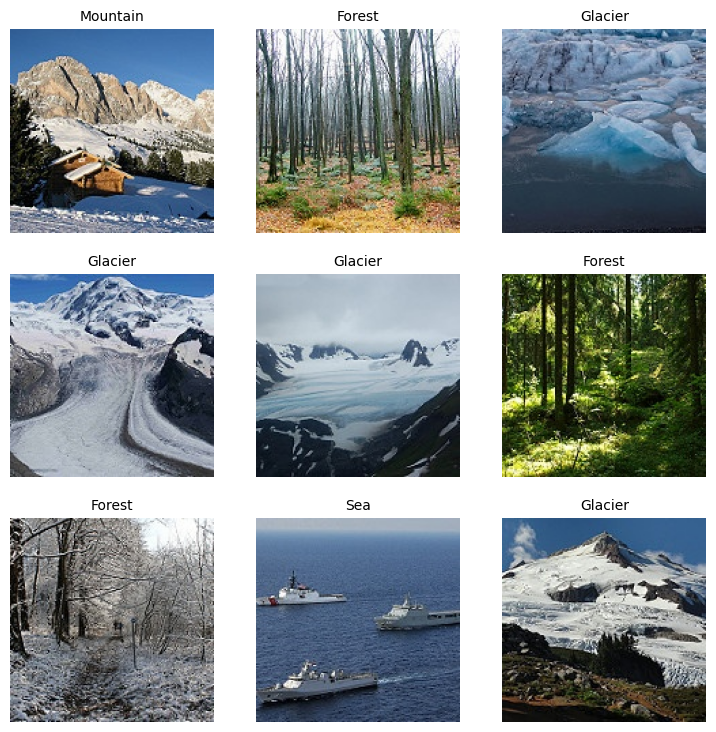

In [4]:
# Visualize 9 random test samples
import random

plt.figure(figsize=(9, 9))

NUM_ROWS = 3
NUM_COLS = 3
i = 1

# Convert each indices to their respective output classes
GET_CLASS = {
    0 : 'Building',
    1 : 'Forest',
    2 : 'Glacier',
    3 : 'Mountain',
    4 : 'Sea',
    5 : 'Street'
}

for idx, sample in random.sample(list(enumerate(test_data)), k=9):
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(sample.tolist())
    plt.title(GET_CLASS[test_targets[idx]], fontsize=10)
    plt.axis(False);

    i += 1

In [5]:
# Let's see how we will convert our data into torch tensors then normalize it (by dividing each by 255.0) for faster model training

temp_tensor = torch.moveaxis(torch.tensor(test_data[i], dtype=torch.float32), -1, 0) / 255.0
print(f"temp_tensor dtype: {temp_tensor.dtype} | temp_tensor shape: {temp_tensor.shape}")
print(temp_tensor)

temp_tensor dtype: torch.float32 | temp_tensor shape: torch.Size([3, 150, 150])
tensor([[[0.5451, 0.6157, 0.6980,  ..., 0.2863, 0.2824, 0.2824],
         [0.6196, 0.7176, 0.8431,  ..., 0.2902, 0.2863, 0.2824],
         [0.6471, 0.7137, 0.7843,  ..., 0.2745, 0.2706, 0.2706],
         ...,
         [0.2196, 0.1451, 0.2588,  ..., 0.0784, 0.1255, 0.1216],
         [0.1686, 0.3647, 0.2353,  ..., 0.0314, 0.0510, 0.0510],
         [0.1725, 0.2000, 0.1765,  ..., 0.0118, 0.0118, 0.0118]],

        [[0.5961, 0.6549, 0.7176,  ..., 0.3843, 0.3843, 0.3843],
         [0.6549, 0.7529, 0.8549,  ..., 0.3882, 0.3882, 0.3843],
         [0.6627, 0.7216, 0.7843,  ..., 0.3725, 0.3686, 0.3686],
         ...,
         [0.2588, 0.1608, 0.2078,  ..., 0.0745, 0.1255, 0.1216],
         [0.2078, 0.3843, 0.2039,  ..., 0.0353, 0.0549, 0.0588],
         [0.2118, 0.2157, 0.1608,  ..., 0.0157, 0.0157, 0.0157]],

        [[0.6196, 0.6588, 0.6941,  ..., 0.5020, 0.4902, 0.4902],
         [0.6745, 0.7490, 0.8275,  ..., 0.5

In [6]:
# Initialize DataLoaders to split data into batches
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(
    [(torch.moveaxis(torch.tensor(train_data[i], dtype=torch.float32), -1, 0) / 255.0, train_targets[i]) for i in range(len(train_data))],
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    [(torch.moveaxis(torch.tensor(test_data[i], dtype=torch.float32), -1, 0) / 255.0, test_targets[i]) for i in range(len(test_data))],
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 219 batches of 64
Length of test dataloader: 47 batches of 64


## 2. Creating CNN Model

We will build our CNN model inspired by the TinyVGG architecture, but with modifications, being:
- Batch Normalization
- Dropouts

The original inspiration for this architecture: https://poloclub.github.io/cnn-explainer/

Of course, more sophisticated CNN models might work better with this dataset. However, for the sake of this project, our model will suffice.

In [7]:
# Build CNN using a modified TinyVGG architecture
# The original inspiration for this architecture: https://poloclub.github.io/cnn-explainer/
class IntelCNN(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int) -> None:
        super().__init__()

        self.convolution_layer_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.Dropout(p=0.1)
        )

        self.convolution_layer_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.Dropout(p=0.15)
        )
        
        self.classification_layer = nn.Sequential( # This is really just a fully-connected and feed-forward layer for classification
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*37*37, out_features=hidden_units),
            nn.BatchNorm1d(num_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=hidden_units, out_features=hidden_units)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convolution_layer_1(x)
        x = self.convolution_layer_2(x)
        x = self.classification_layer(x)
        
        return x

In [8]:
# Model initialization
model = IntelCNN(
    input_shape=3, # the number of colour channels
    output_shape=len(OUTPUT_CLASSES), # the number of output classes (in our case, 6)
    hidden_units=10 # in accordance with TinyVGG
)

model

IntelCNN(
  (convolution_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (convolution_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## 3. Training & Testing Model

In [9]:
# Setup loss function and optimizer for training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.01)

In [10]:
# Create necessary functions to train and test model

def train(model: torch.nn.Module,
          data_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim,
          accuracy_fn) -> dict:

    train_loss, train_acc = 0.0, 0.0

    model.train()

    for X, y in data_loader:
        logits = model(X)
        preds = logits.argmax(dim=1)

        loss = loss_fn(logits, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=preds)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    # Divide by length of dataloader to get average loss and accuracy per batch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    return {
        'loss' : train_loss,
        'acc' : train_acc
    }


def test(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim,
         accuracy_fn) -> dict:

    test_loss, test_acc = 0.0, 0.0

    model.eval()

    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            logits = model(X)
            preds = logits.argmax(dim=1)

            loss = loss_fn(logits, y)
            test_loss += loss
            test_acc += accuracy_fn(y_true=y, y_pred=preds)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    return {
        'loss' : test_loss,
        'acc' : test_acc
    }

In [11]:
# Train model
TRAIN_MODEL = True

if TRAIN_MODEL:
    from timeit import default_timer as timer 
    
    START_TIME = timer()
    EPOCHS = 10
    
    for epoch in range(EPOCHS):
        train_step = train(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn
        )
    
        test_step = test(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn
        )
    
        print(f"Epoch: {epoch} | Train Loss: {train_step['loss']} | Train Acc: {train_step['acc']:.2f}% | Test Loss: {test_step['loss']} | Test Acc: {test_step['acc']:.2f}%")
    
    END_TIME = timer()
    
    TOTAL_TRAIN_TIME = print_train_time(
        start=START_TIME,
        end=END_TIME,
        device='cpu'
    )

Epoch: 0 | Train Loss: 1.2095611095428467 | Train Acc: 51.18% | Test Loss: 0.9622515439987183 | Test Acc: 60.23%
Epoch: 1 | Train Loss: 0.8944215178489685 | Train Acc: 64.43% | Test Loss: 0.915929913520813 | Test Acc: 67.80%
Epoch: 2 | Train Loss: 0.7710093259811401 | Train Acc: 70.62% | Test Loss: 0.6683320999145508 | Test Acc: 76.72%
Epoch: 3 | Train Loss: 0.7084992527961731 | Train Acc: 72.97% | Test Loss: 0.6217250227928162 | Test Acc: 77.70%
Epoch: 4 | Train Loss: 0.6714810132980347 | Train Acc: 74.64% | Test Loss: 0.8101712465286255 | Test Acc: 71.16%
Epoch: 5 | Train Loss: 0.633264422416687 | Train Acc: 76.32% | Test Loss: 0.6029534339904785 | Test Acc: 77.98%
Epoch: 6 | Train Loss: 0.612288773059845 | Train Acc: 76.50% | Test Loss: 0.6729068756103516 | Test Acc: 74.67%
Epoch: 7 | Train Loss: 0.5858953595161438 | Train Acc: 77.80% | Test Loss: 0.6317268013954163 | Test Acc: 77.77%
Epoch: 8 | Train Loss: 0.5592681765556335 | Train Acc: 78.17% | Test Loss: 0.5570931434631348 | Tes

As you can see, our model reaches around 80% accuracy.

## 4. Saving Model

In [12]:
SAVE_MODEL = True

from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "intel_image_cnn.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

if SAVE_MODEL:
    # Save the model state dict
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
               f=MODEL_SAVE_PATH)

Saving model to: models\intel_image_cnn.pth


In [13]:
# Load saved model
torch.manual_seed(42)

loaded_state_dict = torch.load(f=MODEL_SAVE_PATH, weights_only=False)

loaded_model = IntelCNN(
    input_shape=3,
    output_shape=len(OUTPUT_CLASSES),
    hidden_units=10
)

# Load in the saved state_dict()
loaded_model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

In [14]:
# Test loaded model accuracy to make sure everything is working properly
test_step = test(
    model=loaded_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_fn=accuracy_fn
)

print(f"Test Loss: {test_step['loss']} | Test Acc: {test_step['acc']:.2f}%")

Test Loss: 0.6294848918914795 | Test Acc: 77.92%


## 5. Evaluating Model

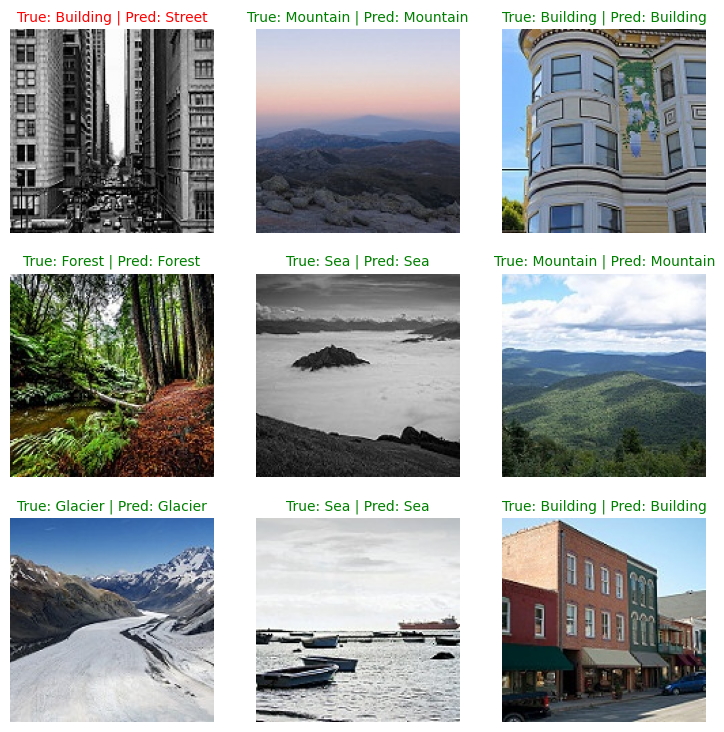

In [15]:
# Visualize how accurate our model is using random test samples
import random

plt.figure(figsize=(9, 9))

NUM_ROWS = 3
NUM_COLS = 3
i = 1

for idx, sample in random.sample(list(enumerate(test_data)), k=9):
    X = torch.moveaxis(torch.tensor(test_data[idx], dtype=torch.float32), -1, 0) / 255.0

    loaded_model.eval()
    with torch.inference_mode():
        logit = loaded_model(X.unsqueeze(dim=0))
        predicted_target = GET_CLASS[int(logit.argmax(dim=1).item())]
    
    true_target = GET_CLASS[test_targets[idx]]
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(sample.tolist())

    title = f"True: {true_target} | Pred: {predicted_target}"

    if predicted_target == true_target:
        plt.title(title, c='g', fontsize=10)
    else:
        plt.title(title, c='r', fontsize=10)
        
    plt.axis(False);

    i += 1

The end :)